In [1]:
import os
import zipfile
import random
from tensorflow import keras as kr
from shutil import copyfile

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset
# Note: This is a very large dataset and will take time to download
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))
# Expected Output:
# 12501
# 12501

--2022-05-03 23:28:35--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 183.61.8.28, 183.61.8.29, 183.61.8.25, ...
Connecting to download.microsoft.com (download.microsoft.com)|183.61.8.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  10.5MB/s    in 74s     

2022-05-03 23:29:50 (10.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]

12501
12501


In [3]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [4]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [5]:
model = kr.models.Sequential([
    kr.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    kr.layers.MaxPooling2D(2, 2),
    kr.layers.Conv2D(32, (3, 3), activation='relu'),
    kr.layers.MaxPooling2D(2, 2),
    kr.layers.Conv2D(64, (3, 3), activation='relu'),
    kr.layers.MaxPooling2D(2, 2),
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=kr.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-03 23:30:18.393806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 23:30:18.393957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/junsircoding/miniforge3/envs/tensor_env/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = kr.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = kr.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22499 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [7]:
# Note that this may take some time.
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

/var/folders/hh/_pxd34ms18d7f5jhh52xs7rr0000gn/T/ipykernel_10840/3717355689.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/15


2022-05-03 23:30:26.606658: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 23:30:26.965870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 10/225 [>.............................] - ETA: 33s - loss: 1.3248 - accuracy: 0.4930

/Users/junsircoding/miniforge3/envs/tensor_env/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.6406

2022-05-03 23:31:03.026865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 40s 173ms/step - loss: 0.6601 - accuracy: 0.6406 - val_loss: 0.9419 - val_accuracy: 0.5568
Epoch 2/15
225/225 [==============================] - 38s 168ms/step - loss: 0.5111 - accuracy: 0.7507 - val_loss: 0.4617 - val_accuracy: 0.7776
Epoch 3/15
225/225 [==============================] - 41s 180ms/step - loss: 0.4328 - accuracy: 0.7963 - val_loss: 0.3904 - val_accuracy: 0.8184
Epoch 4/15
225/225 [==============================] - 45s 200ms/step - loss: 0.3760 - accuracy: 0.8300 - val_loss: 0.3185 - val_accuracy: 0.8588
Epoch 5/15
225/225 [==============================] - 47s 207ms/step - loss: 0.3134 - accuracy: 0.8614 - val_loss: 0.2405 - val_accuracy: 0.9152
Epoch 6/15
225/225 [==============================] - 47s 209ms/step - loss: 0.2502 - accuracy: 0.8948 - val_loss: 0.1601 - val_accuracy: 0.9456
Epoch 7/15
225/225 [==============================] - 47s 207ms/step - loss: 0.1878 - accuracy: 0.9225 - val_loss: 0.1112 - val_accuracy: 0.9

<Figure size 432x288 with 0 Axes>

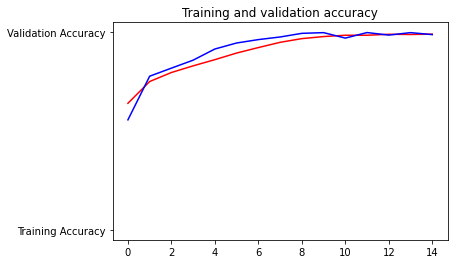

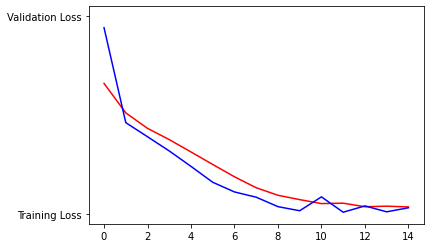

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")